# 0. Introduction

This notebook implements code that learns the distribution of Monet paintings as available on <a href = 'https://www.kaggle.com/c/gan-getting-started/data' >Kaggle</a>. This is achieved with the help of a GAN network i.e a **Generative Adverserial Network**. This is to generate new Monet-like paintings using the Generator Network.

# 1. **Required Libraries & Loading Data**

In [1]:
import os

# General Data Manipulation Libraries
import numpy as np
import pandas as pd

# Image Libraries
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

# PyTorch Libraries
import torch
import torchvision
import torchvision.transforms as transforms
 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision.utils import save_image
from torchvision.utils import make_grid

from torchvision import datasets, transforms

from torchsummary import summary

# Plotting Tools
import matplotlib.pyplot as plt

## Global Parameters

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'  
    torch.set_default_tensor_type('torch.FloatTensor')

In [3]:
# device = 'cpu'  
# torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
# Latent vector (i.e. size of generator input)
nz = 200
# Size of feature maps in generator
ngf = 32
# Size of feature maps in discriminator
ndf = 32
# Number of channels in the training images. For color images this is 3
nc = 3
# Batch Size
batch_size = 32
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

## Loading Data

In [5]:
# Clearing CUDA cache
torch.cuda.empty_cache()

# Data File Directories
TRAIN_DIR = os.getcwd()
data_dir  = TRAIN_DIR + '/data'
monet_dir = data_dir + '/monet_jpg'
photo_dir = data_dir + '/photo_jpg'

# Necessary Transformation on Dataset
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Loading Dataset
monet_dataset = datasets.ImageFolder(monet_dir, transform=transform)
photo_dataset = datasets.ImageFolder(photo_dir, transform=transform)

# Create Dataloader for Datasets
monet_dataloader = torch.utils.data.DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_dataloader = torch.utils.data.DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

# **2. Exploratory Data Analysis/ Data Inspection**

Sample Images is displayed from each of the Datasets. The Size of these Images is displayed.

In [6]:
print(f'The Size of Monet Dataset is {len(monet_dataset)} and the size of the Photo Dataset is {len(photo_dataset)}.')

The Size of Monet Dataset is 300 and the size of the Photo Dataset is 7038.


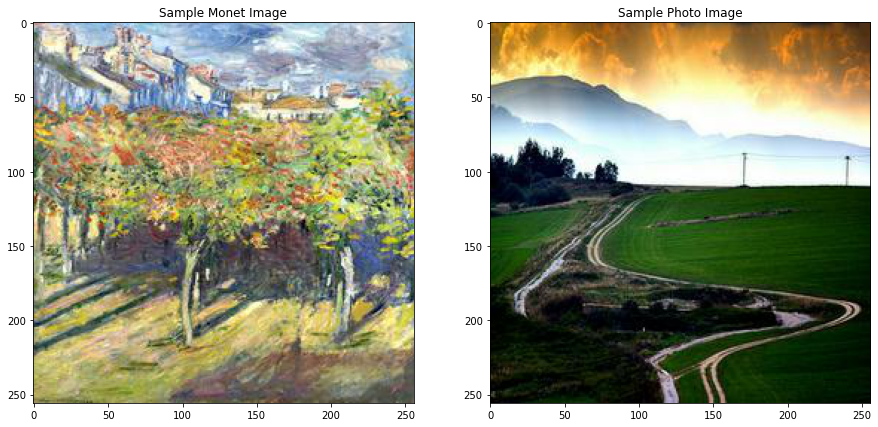

In [7]:
# Display Sample Image from DataLoaders
'''
iter() - Converts the DataLoader Object to an iterable Object.
next() - Calls the next object of the given iterator.
'''
monets, labels_monets = next(iter(monet_dataloader))
photos, labels_photos = next(iter(photo_dataloader))
# Plotting
f, ax = plt.subplots(1,2)
f.set_size_inches((15, 15))
ax[0].set_title("Sample Monet Image")
ax[0].imshow(np.transpose(monets[0].numpy(), (1, 2, 0)))

#plt.title('Sample Monet Image')
ax[1].set_title("Sample Photo Image")
ax[1].imshow(np.transpose(photos[0].numpy(), (1, 2, 0)))

In [8]:
# Image Sizes
sample = monets[0].numpy()
img_size_width = sample.shape[1]
img_size_height = sample.shape[2]
channels = sample.shape[0]

print(f'The images is of size {img_size_width} x {img_size_height} with {channels} channels ')
img_shape = (channels, img_size_width, img_size_height)

The images is of size 256 x 256 with 3 channels 


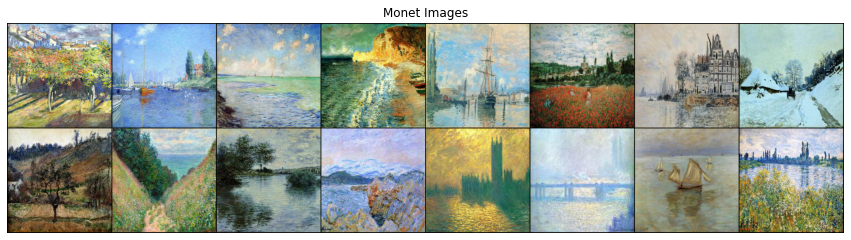

In [9]:
real_batch = next(iter(monet_dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Monet Images");
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))

# **3. Training Parameters**

In [10]:
# Training Parameters
n_epochs = 200
learning_rate = 0.0001
latent_dim = 100

# Adam Parameters
b1 = 0.3
b2 = 0.999

sample_interval = 400

# **4. DCGAN Model Architecture**

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Initialize generator
netG = Generator().to(device);
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [13]:
if device == 'cuda':
    summary(netG, (200, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       3,276,800
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
              ReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
              ReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
             ReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Initialize Discriminator    
netD = Discriminator().to(device);
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [15]:
if device == 'cuda':
    summary(netD, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,536
         LeakyReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]          32,768
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         LeakyReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 32, 32]         131,072
       BatchNorm2d-7          [-1, 128, 32, 32]             256
         LeakyReLU-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]         524,288
      BatchNorm2d-10          [-1, 256, 16, 16]             512
        LeakyReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [16]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

if device == 'cuda':
    adversarial_loss.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(b1, b2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(b1, b2))

# **5. Load Dataset & Training Parameters**

In [17]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [18]:
# Make Generated Images Directory
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image((fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# **6. Training the GAN**

In [20]:
### print("Starting Training Loop...")
# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(monet_dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D     
       
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizer_D.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = adversarial_loss(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_G.step()
        
        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(monet_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == n_epochs-1) and (i == len(monet_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))
            
        iters += 1

[0/200][0/10]	Loss_D: 1.7764	Loss_G: 9.5532	D(x): 0.5996	D(G(z)): 0.5579 / 0.0001
[0/200][5/10]	Loss_D: 0.3470	Loss_G: 7.2516	D(x): 0.8848	D(G(z)): 0.1133 / 0.0011
[1/200][0/10]	Loss_D: 0.0715	Loss_G: 9.0353	D(x): 0.9413	D(G(z)): 0.0020 / 0.0002
[1/200][5/10]	Loss_D: 0.5705	Loss_G: 7.2238	D(x): 0.8591	D(G(z)): 0.0681 / 0.0012
[2/200][0/10]	Loss_D: 0.5054	Loss_G: 14.4022	D(x): 0.7479	D(G(z)): 0.0000 / 0.0000
[2/200][5/10]	Loss_D: 0.0089	Loss_G: 14.4675	D(x): 0.9914	D(G(z)): 0.0000 / 0.0000
[3/200][0/10]	Loss_D: 0.1564	Loss_G: 9.9095	D(x): 0.9550	D(G(z)): 0.0631 / 0.0001
[3/200][5/10]	Loss_D: 0.3139	Loss_G: 12.0242	D(x): 0.8554	D(G(z)): 0.0001 / 0.0000
[4/200][0/10]	Loss_D: 0.0000	Loss_G: 39.4140	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/200][5/10]	Loss_D: 0.0000	Loss_G: 39.1732	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/200][0/10]	Loss_D: 0.0000	Loss_G: 39.1056	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/200][5/10]	Loss_D: 0.0000	Loss_G: 39.1393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/200][0

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()